In [12]:
import pandas as pd
import json
import numpy as np
import re
import matplotlib.pyplot as plt
import glob 
import math
import h5py
import os

from sac_utils import replace_blinks_with_nan

In [49]:
with open('/Users/sinakling/projects/pRF_analysis/RetinoMaps/eyetracking/dev/PurLoc_SacLoc/behavior_settings.json') as f:
	json_s = f.read()
	analysis_info = json.loads(json_s)

num_run = analysis_info['num_run']
num_seq = analysis_info['num_seq']
seq_trs = analysis_info['seq_trs']
eye_mov_seq = analysis_info['eye_mov_seq']
rads = analysis_info['rads']
pursuits_tr = np.arange(0,seq_trs,2)
saccades_tr = np.arange(1,seq_trs,2)

# Define file list
main_dir = analysis_info['main_dir_mac']
file_dir_save = f'/Users/sinakling/Desktop/RetinoMaps_Data'

subject = 'sub-04'
task = 'PurLoc'
ses = 'ses-02'
eye = 'eye1'

In [50]:
data_events = sorted(glob.glob(r'{exp_dir}/{sub}/{ses}/func/{sub}_{ses}_task-{task}_*_events*.tsv'.format(exp_dir=main_dir, sub=subject, ses = ses, task = task)))

if subject == 'sub-01': 
    ses = 'ses-01'
    data_events = sorted(glob.glob(r'{exp_dir}/{sub}/{ses}/func/{sub}_{ses}_task-{task}_*_events*.tsv'.format(exp_dir=main_dir, sub=subject, ses = ses, task = task)))

In [16]:
print(data_events)

['/Users/sinakling/disks/meso_shared/RetinoMaps/sub-04/ses-02/func/sub-04_ses-02_task-PurLoc_run-01_events.tsv', '/Users/sinakling/disks/meso_shared/RetinoMaps/sub-04/ses-02/func/sub-04_ses-02_task-PurLoc_run-02_events.tsv']


In [51]:

def extract_data(main_dir, subject, task, runs, file_type):
    '''read tsv.gsv data as pandas dataframes. Use information from json as columns'''
    df_runs = []
    for run in range(runs):
        json_file_path = f'{main_dir}/{subject}/{ses}/func/{subject}_{ses}_task-{task}_run-0{run+1}_eyeData_recording-{eye}_{file_type}.json'
        tsv_file_path = f"{main_dir}/{subject}/{ses}/func/{subject}_{ses}_task-{task}_run-0{run+1}_eyeData_recording-{eye}_{file_type}.tsv.gz"
        

        with open(json_file_path, 'r') as file:
            json_data = json.load(file)

        # Extract column names from the JSON
        column_names = json_data['Columns']

        df = pd.read_csv(
            tsv_file_path, 
            compression='gzip', 
            delimiter='\t', 
            header=None,  
            names=column_names,  # Use the column names from JSON
            na_values='n/a'  # Treat 'n/a' as NaN
        )

        df_runs.append(df)

    return df_runs


df_event_runs = extract_data(main_dir, subject, task, num_run, file_type = "physioevents")
df_data_runs = extract_data(main_dir, subject, task, num_run, file_type = "physio")


In [53]:
print(df_event_runs[0])

         onset  duration trial_type  blink       message
0     28730633       NaN        NaN    NaN  RECORD_START
1     28730580      90.0   fixation    0.0           NaN
2     28730670      21.0    saccade    0.0           NaN
3     28730691     164.0   fixation    0.0           NaN
4     28730855      42.0    saccade    0.0           NaN
...        ...       ...        ...    ...           ...
5122  29005828     497.0   fixation    0.0           NaN
5123  29006325      18.0    saccade    0.0           NaN
5124  29006343     131.0   fixation    0.0           NaN
5125  29006474     401.0    saccade    1.0           NaN
5126  29006875      60.0   fixation    0.0           NaN

[5127 rows x 5 columns]


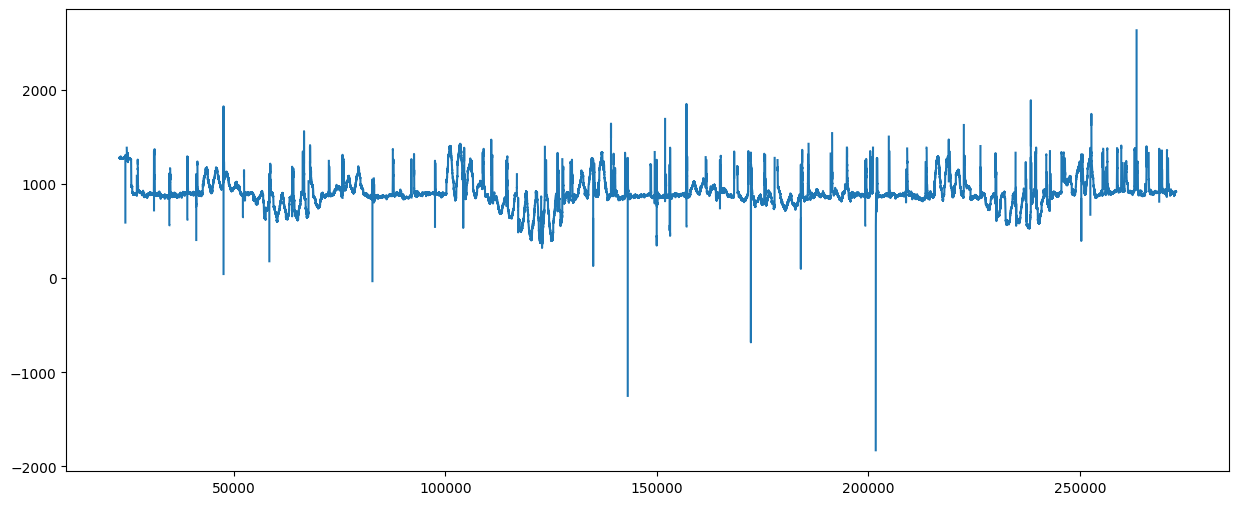

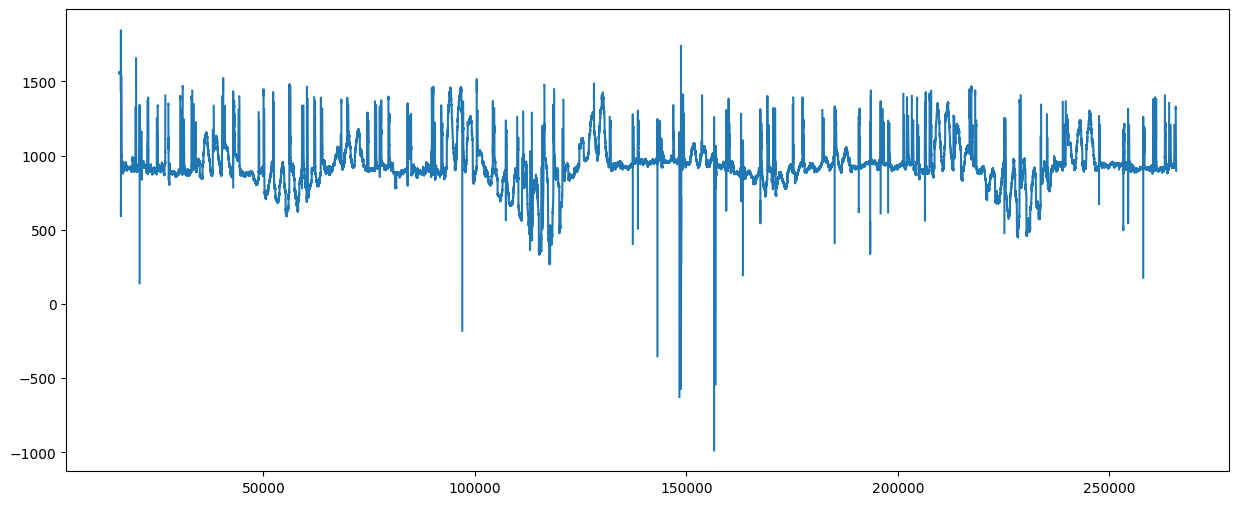

In [54]:
# Extract timestamps


# Initialize arrays to store results
time_start_eye = np.zeros((1, num_run))
time_end_eye = np.zeros((1, num_run))
time_start_seq = np.zeros((num_seq, num_run))
time_end_seq = np.zeros((num_seq, num_run))
time_start_trial = np.zeros((seq_trs, num_seq, num_run))
time_end_trial = np.zeros((seq_trs, num_seq, num_run))

# Lists to collect record lines
record_lines = []
ongoing_trials = {}

# Regex patterns for matching
record_start_pattern = r'RECORD_START'
record_stop_pattern = r'RECORD_STOP'
seq_start_pattern = r'sequence\s(\d+)\sstarted'
seq_stop_pattern = r'sequence\s(\d+)\sstopped'
trial_onset_pattern = r'trial\s(\d+)\sonset'
trial_offset_pattern = r'trial\s(\d+)\soffset'
seq_9_stop_pattern = r'sequence\s9\strial\s16\soffset'
seq_1_start_pattern = r'sequence\s1\strial\s1\sonset'

# Loop through the 'messages' column to extract the patterns
for run_idx, df in enumerate(df_event_runs):
    for index, row in df.iterrows():
        message = row['message']
        
        if pd.isna(message):
            continue  # Skip if NaN
        
        # Check for RECORD_START and RECORD_STOP
        if re.search(record_start_pattern, message):
            record_lines.append(row['onset'])
        elif re.search(record_stop_pattern, message):
            record_lines.append(row['onset'])
        
        # Check for sequence 1 started
        if re.search(seq_1_start_pattern, message):
            time_start_eye[0, run_idx] = row['onset']  # Store by run index
            

        # Check for sequence start
        seq_start_match = re.search(seq_start_pattern, message)
        if seq_start_match:
            seq_num = int(seq_start_match.group(1))
            last_seq_num = seq_num  # Save sequence number for trial matching
            time_start_seq[seq_num - 1, run_idx] = row['onset']  

        # Check for sequence stop
        seq_stop_match = re.search(seq_stop_pattern, message)
        if seq_stop_match:
            seq_num = int(seq_stop_match.group(1))
            time_end_seq[seq_num - 1, run_idx] = row['onset']  
        # Check for sequence stop
        seq_stop_match = re.search(seq_stop_pattern, message)
        if seq_stop_match:
            seq_num = int(seq_stop_match.group(1))
            time_end_seq[seq_num - 1, run_idx] = row['onset']

        # Check for trial onset
        trial_onset_match = re.search(trial_onset_pattern, message)
        if trial_onset_match:
            trial_num = int(trial_onset_match.group(1))
            if last_seq_num is not None:  # Ensure sequence has been identified
                time_start_trial[trial_num - 1, last_seq_num - 1, run_idx] = row['onset']
                # Store ongoing trial in case offset is found later
                ongoing_trials[trial_num] = row['onset']

        # Check for trial offset (ensure it's stored after the onset)
        trial_offset_match = re.search(trial_offset_pattern, message)
        if trial_offset_match:
            trial_num = int(trial_offset_match.group(1))
            # Check if this trial has an ongoing onset recorded
            if trial_num in ongoing_trials:
                if last_seq_num is not None:
                    time_end_trial[trial_num - 1, last_seq_num - 1, run_idx] = row['onset']
                    del ongoing_trials[trial_num]  # Remove from ongoing trials as offset is found
            else:
                # Trial offset found without a matching onset, this means it was out of order
                print(f"Out-of-order trial offset found for trial {trial_num}, but onset wasn't found.")
            


        # Check for sequence 9 stopped
        if re.search(seq_9_stop_pattern, message):
            time_end_eye[0, run_idx] = row['onset']
            


    eye_data_run = df_data_runs[run_idx][(df_data_runs[run_idx]['timestamp'] >= time_start_eye[0, run_idx]) & 
                       (df_data_runs[run_idx]['timestamp'] <= time_end_eye[0, run_idx])]
    
    plt_1 = plt.figure(figsize=(15, 6))
    plt.plot(eye_data_run['x_coordinate'])
    plt.show()


    eye_data_run = np.concatenate((eye_data_run,np.ones((eye_data_run.shape[0],1))*(run_idx)),axis = 1)
	# col 0 = time
	# col 2 = eye x coord
	# col 3 = eye y coord
	# col 4 = run number

    if run_idx == 0:
        eye_data_runs = eye_data_run
    else:
        eye_data_runs = np.concatenate((eye_data_runs,eye_data_run), axis=0)

            

 - blink replacement with NaN


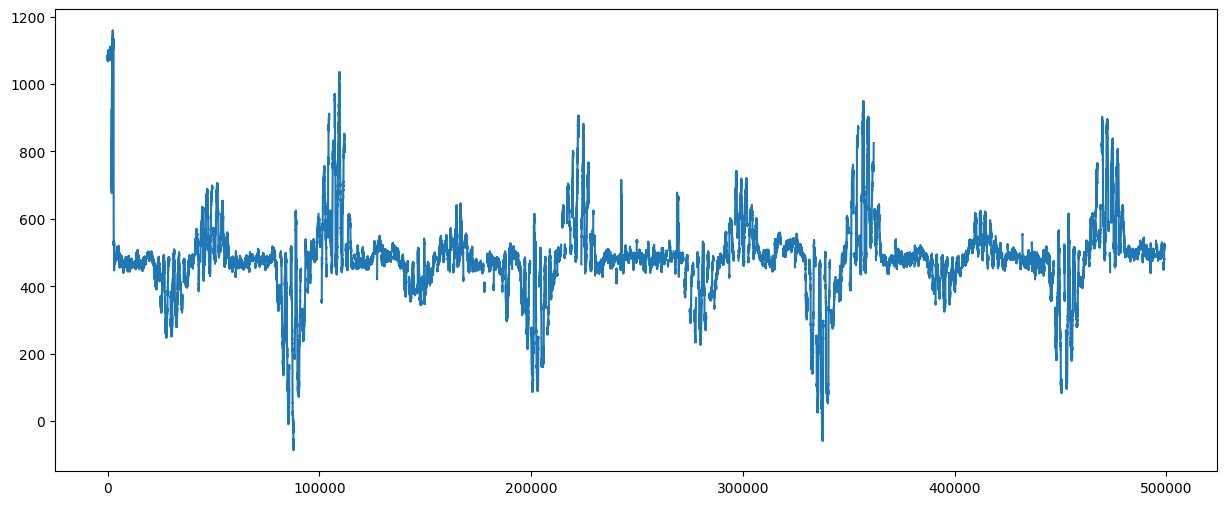

In [55]:
# Remove blinks 
# Put nan for blink time
sampling_rate = 1000
eye_data_runs_nan_blink = replace_blinks_with_nan(eye_data_runs,sampling_rate)

plt_2 = plt.figure(figsize=(15, 6))
plt.plot(eye_data_runs_nan_blink[:,2])
plt.show()


In [56]:
time_start_trial[0,0,0] = 28753515
time_start_trial[0,1,0] = 28772806 # trial, seq, run 


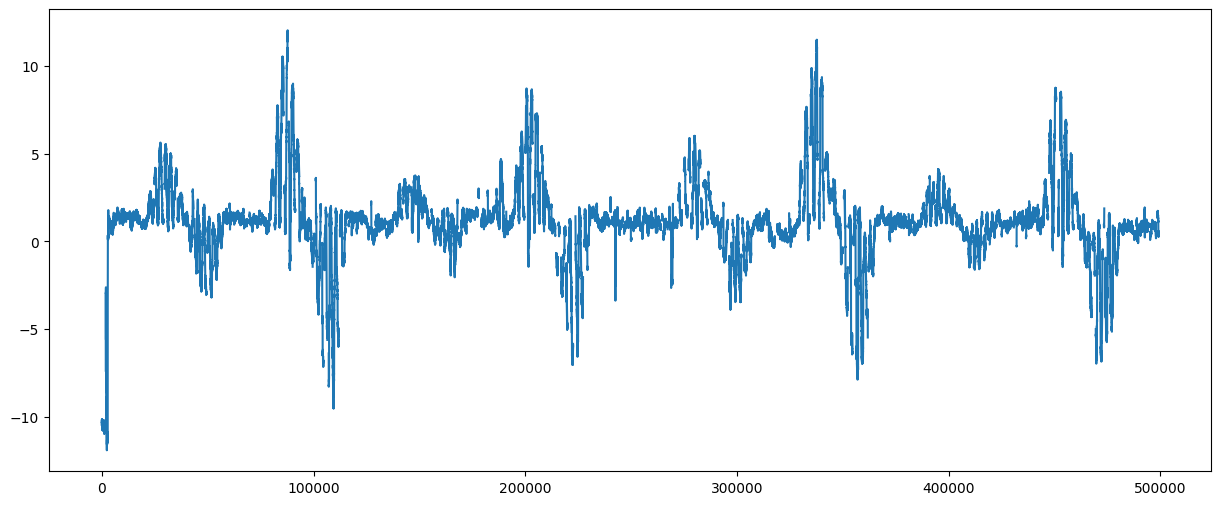

In [58]:
# Flip Y axis and convert to dva 

scr_sizeX = 1920
scr_sizeY = 1080
screen_size = np.array([scr_sizeX,scr_sizeY])
ppd = 52.00031911320716


eye_data_runs[:,1] = (eye_data_runs[:,1] - (screen_size[0]/2))/ppd
eye_data_runs[:,2] = -1.0*((eye_data_runs[:,2] - (screen_size[1]/2))/ppd)

eye_data_runs_nan_blink[:,1] = (eye_data_runs_nan_blink[:,1] - (screen_size[0]/2))/ppd
eye_data_runs_nan_blink[:,2] = -1.0*((eye_data_runs_nan_blink[:,2] - (screen_size[1]/2))/ppd)

plt_3 = plt.figure(figsize=(15, 6))
plt.plot(eye_data_runs_nan_blink[:,2])
plt.show()

In [59]:
# get amplitude sequence from event files
dfs = []
legend_amp = {1: 4, 2: 6, 3: 8, 4: 10, 5: "none"}
    
for file_path in data_events:
	df = pd.read_csv(file_path, sep='\t')
	dfs.append(df)

appended_df = pd.concat(dfs, ignore_index=True)
amp_sequence_ev = list(appended_df['eyemov_amplitude'])

amp_sequence = [legend_amp[val] if not math.isnan(val) else float('nan') for val in amp_sequence_ev]

In [60]:
# save as h5 
if not os.path.exists(f"{file_dir_save}/{subject}"): 
    os.makedirs(f"{file_dir_save}/{subject}") 


h5_file = '{file_dir}/{sub}/{sub}_task-{task}_eyedata.h5'.format(file_dir = file_dir_save, sub = subject, task = task)


try:
    os.system(f'rm "{h5_file}"')  
except:
    pass

h5file = h5py.File(h5_file, "a")


# Creating datasets
h5file.create_dataset(f'eye_data_runs', data=eye_data_runs, dtype='float32')
h5file.create_dataset(f'eye_data_runs_nan_blink', data=eye_data_runs_nan_blink, dtype='float32')
h5file.create_dataset(f'time_start_eye', data=time_start_eye, dtype='float32')
h5file.create_dataset(f'time_end_eye', data=time_end_eye, dtype='float32')
h5file.create_dataset(f'time_start_seq', data=time_start_seq, dtype='float32')
h5file.create_dataset(f'time_end_seq', data=time_end_seq, dtype='float64')
h5file.create_dataset(f'time_start_trial', data=time_start_trial, dtype='float32')
h5file.create_dataset(f'time_end_trial', data=time_end_trial, dtype='float32')
h5file.create_dataset(f'amp_sequence', data=amp_sequence_ev, dtype='float32')
#h5file.create_dataset(f'recording_times', data=record_array, dtype='float32')


h5file.close()

rm: /Users/sinakling/Desktop/RetinoMaps_Data/sub-04/sub-04_task-PurLoc_eyedata.h5: No such file or directory
